In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



In [2]:
df = pd.read_csv('NFLX.csv')
df
df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
df.head()

,date,open,high,low,close,adj_close,volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [3]:
print("Total number of days: ",df.shape[0])
print("Total number of features: ",df.shape[1])

Total number of days:  1009
Total number of features:  7


In [4]:
df['date'] = pd.to_datetime(df['date'], utc=True)


In [5]:
df_close = df[['date','close']]

df_close_original = df_close.copy()

print("Shape of close dataframe:", df_close.shape)
df_close

Shape of close dataframe: (1009, 2)


,date,close
0,2018-02-05 00:00:00+00:00,254.259995
1,2018-02-06 00:00:00+00:00,265.720001
2,2018-02-07 00:00:00+00:00,264.559998
3,2018-02-08 00:00:00+00:00,250.100006
4,2018-02-09 00:00:00+00:00,249.470001
...,...,...
1004,2022-01-31 00:00:00+00:00,427.140015
1005,2022-02-01 00:00:00+00:00,457.130005
1006,2022-02-02 00:00:00+00:00,429.480011
1007,2022-02-03 00:00:00+00:00,405.600006


In [6]:
training_size=int(len(df_close)*0.80)

test_size=len(df_close)-training_size

train_data,test_data = df_close[0:training_size],df_close[training_size:len(df_close)]

print("train_data: ", train_data.shape)

print("test_data: ", test_data.shape)

train_data:  (807, 2)
test_data:  (202, 2)


In [7]:

del train_data['date']
del test_data['date']

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(df_close.shape)


time_step = 14

(1009, 2)


In [9]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:

X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

for i in range(15):
    print(X_train[i][:5])


X_train:  (792, 14)
y_train:  (792,)
X_test:  (187, 14)
y_test (187,)
[0.05782213 0.09033648 0.08704531 0.04601941 0.04423196]
[0.09033648 0.08704531 0.04601941 0.04423196 0.06829145]
[0.08704531 0.04601941 0.04423196 0.06829145 0.06919929]
[0.04601941 0.04423196 0.06829145 0.06919929 0.09113089]
[0.04423196 0.06829145 0.06919929 0.09113089 0.13161772]
[0.06829145 0.06919929 0.09113089 0.13161772 0.12665262]
[0.06919929 0.09113089 0.13161772 0.12665262 0.12673773]
[0.09113089 0.13161772 0.12665262 0.12673773 0.13380242]
[0.13161772 0.12665262 0.12673773 0.13380242 0.12557455]
[0.12665262 0.12673773 0.13380242 0.12557455 0.14767629]
[0.12673773 0.13380242 0.12557455 0.14767629 0.17102649]
[0.13380242 0.12557455 0.14767629 0.17102649 0.16095437]
[0.12557455 0.14767629 0.17102649 0.16095437 0.16313907]
[0.14767629 0.17102649 0.16095437 0.16313907 0.16033027]
[0.17102649 0.16095437 0.16313907 0.16033027 0.19057476]


In [11]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 14, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs= 100
batch_size = 16

model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size)

Epoch 1/100
50/50 [==============================] - 4s 9ms/step - loss: 0.0250
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 6/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 8/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 9/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 10/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 11/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 12/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 13/100
50/50 [=================

In [14]:
# test_predict=model.predict(X_test[-time_step:])
# print(X_test[-1])
# print("-----------------------------")
# print(X_test[-2:])
# print("-----------------------------")
# print(test_predict)

In [15]:

predictions = []

last_prices = X_train#[-time_step:]
for i in range(test_data.shape[0]):
    temp_row = time_step*[0]

    for i in range(time_step-1):
        temp_row[i] = last_prices[-1][i+1]


    prediction= model.predict(last_prices[-200:])[0,0] #last_prices[-15:]
    temp_row[-1] = prediction
    predictions.append(prediction)

    last_prices = np.vstack((last_prices,temp_row))

# print(temp_row)
# print(last_prices)
print(predictions)

7/7 [==============================] - 0s 2ms/step
[0.6652062, 0.6508396, 0.6866889, 0.6887156, 0.7107178, 0.724558, 0.81976116, 0.7750182, 0.7681654, 0.7652465, 0.7754947, 0.6971686, 0.7118741, 0.6867049, 0.68346083, 0.6547531, 0.65858674, 0.69516385, 0.6814999, 0.6693351, 0.67126465, 0.6790042, 0.70245796, 0.7299708, 0.7142912, 0.72835624, 0.6967246, 0.6670304, 0.62632966, 0.6437141, 0.6605835, 0.6647198, 0.6633841, 0.68512416, 0.66985273, 0.6990738, 0.6891258, 0.67931235, 0.68281984, 0.81510806, 0.77801013, 0.76659226, 0.7795018, 0.8431704, 0.84046686, 0.7776309, 0.7499107, 0.7282444, 0.7114167, 0.6645677, 0.66349447, 0.6508421, 0.6957395, 0.6712915, 0.6349628, 0.63103247, 0.672717, 0.68565726, 0.63705134, 0.63742936, 0.6620257, 0.68280125, 0.69055796, 0.7058258, 0.77059233, 0.71965694, 0.75444734, 0.72483647, 0.78841054, 0.78839254, 0.80488515, 0.8073101, 0.8401195, 0.81456375, 0.81326616, 0.7884329, 0.7864667, 0.77479994, 0.6891327, 0.6720334, 0.67981935, 0.6809416, 0.6818893, 0.6

In [16]:
predictions_array = np.array(predictions)
predictions_reshaped = predictions_array.reshape(-1,1)
predicted_prices = scaler.inverse_transform(predictions_reshaped)
predicted_prices

array([[468.33862],
       [463.27496],
       [475.9104 ],
       [476.62473],
       [484.37964],
       [489.25775],
       [522.81305],
       [507.04297],
       [504.6276 ],
       [503.59882],
       [507.2109 ],
       [479.60406],
       [484.7872 ],
       [475.91605],
       [474.77264],
       [464.6543 ],
       [466.00552],
       [478.8975 ],
       [474.08148],
       [469.79388],
       [470.47397],
       [473.20184],
       [481.46835],
       [491.16556],
       [485.63913],
       [490.59647],
       [479.44757],
       [468.98154],
       [454.6362 ],
       [460.7635 ],
       [466.7093 ],
       [468.16718],
       [467.69638],
       [475.3589 ],
       [469.97632],
       [480.27557],
       [476.76932],
       [473.31046],
       [474.54672],
       [521.17303],
       [508.0975 ],
       [504.07315],
       [508.62323],
       [531.0639 ],
       [530.11096],
       [507.96384],
       [498.19357],
       [490.55707],
       [484.62598],
       [468.1136 ],


In [17]:
test_prices = scaler.inverse_transform(test_data)
train_prices = scaler.inverse_transform(train_data)
test_prices

array([[508.899994],
       [508.779999],
       [505.549988],
       [510.299988],
       [505.549988],
       [506.519989],
       [509.      ],
       [513.469971],
       [509.109985],
       [503.179993],
       [496.079987],
       [499.549988],
       [503.839996],
       [486.690002],
       [495.079987],
       [484.980011],
       [486.660004],
       [493.369995],
       [488.940002],
       [486.279999],
       [487.700012],
       [501.670013],
       [497.890015],
       [502.899994],
       [501.339996],
       [502.359985],
       [503.859985],
       [502.809998],
       [499.079987],
       [499.23999 ],
       [489.429993],
       [494.73999 ],
       [494.660004],
       [492.390015],
       [485.809998],
       [487.269989],
       [488.769989],
       [499.890015],
       [491.899994],
       [492.410004],
       [498.339996],
       [500.769989],
       [497.      ],
       [508.820007],
       [512.73999 ],
       [518.059998],
       [527.070007],
       [533.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


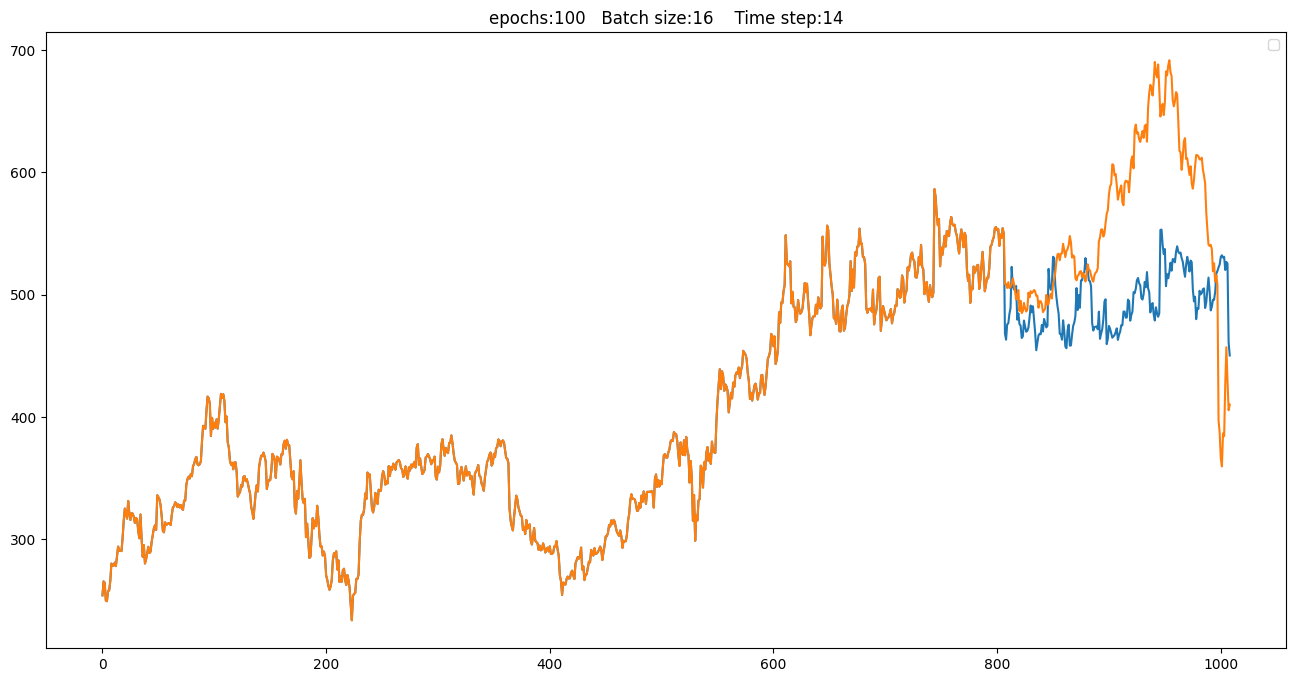

In [18]:
import matplotlib.pyplot as plt

# plt.plot(train_prices+predicted_prices)
# plt.plot(train_prices+test_prices)
plt.figure(figsize = (16,8))
plt.plot(np.vstack((train_prices,predicted_prices)))
plt.plot(np.vstack((train_prices,test_prices)))
title = "epochs:"+ str(epochs)+"   Batch size:"+str(batch_size)+"    Time step:"+str(time_step)
plt.title(title)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


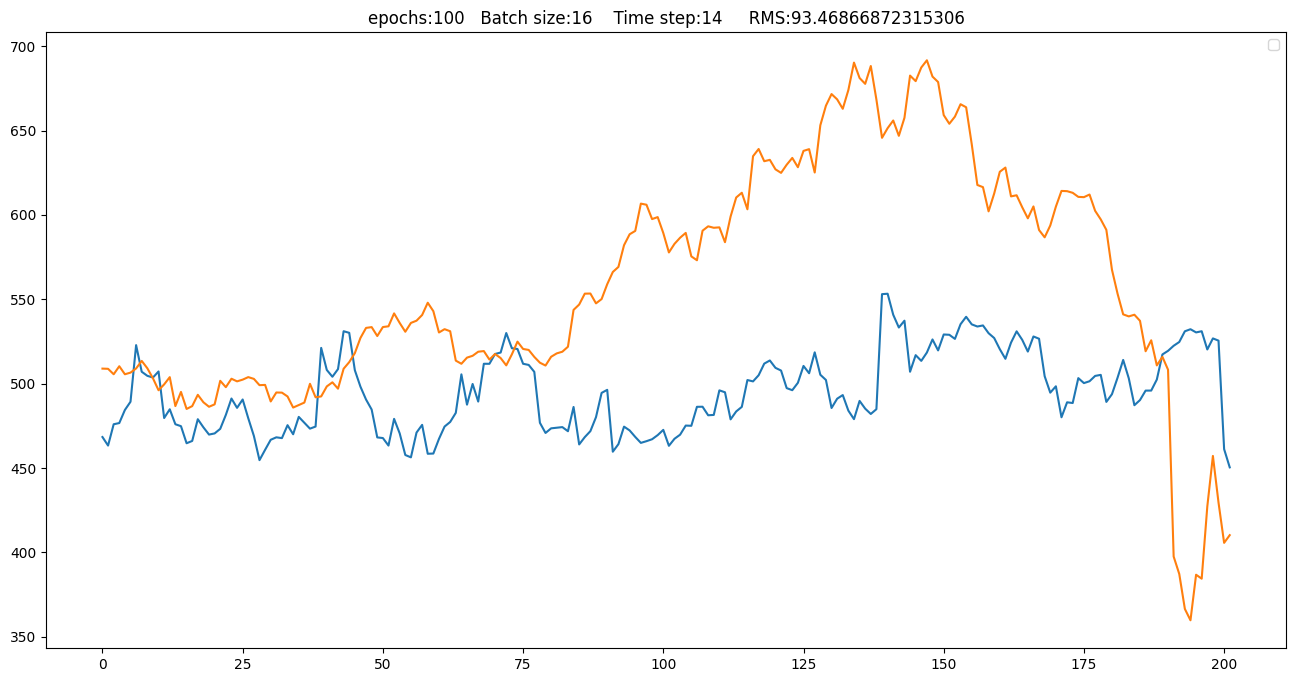

In [19]:
plt.figure(figsize = (16,8))
plt.plot(np.vstack((predicted_prices)))
plt.plot(np.vstack((test_prices)))
rms =  math.sqrt(mean_squared_error(test_prices,predicted_prices))

title = "epochs:"+ str(epochs)+"   Batch size:"+str(batch_size)+"    Time step:"+str(time_step) +"     RMS:"+str(rms)
plt.title(title)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


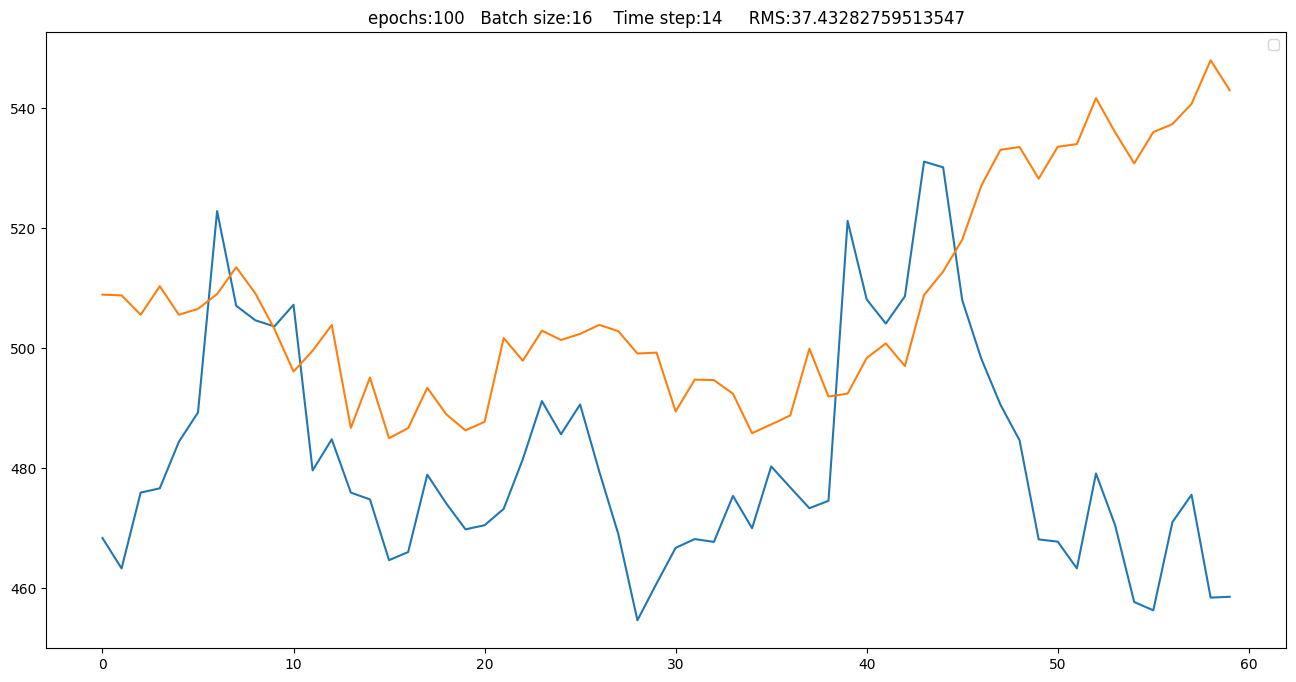

In [20]:
plt.figure(figsize = (16,8))
plt.plot(np.vstack((predicted_prices[:60])))
plt.plot(np.vstack((test_prices[:60])))
rms =  math.sqrt(mean_squared_error(test_prices[:60],predicted_prices[:60]))

title = "epochs:"+ str(epochs)+"   Batch size:"+str(batch_size)+"    Time step:"+str(time_step) +"     RMS:"+str(rms)
plt.title(title)
plt.legend()
plt.show()